# Clasificación de emociones en audio del Dataset CREMA-D.
Basado en código de Mari et. al (https://github.com/XanaduAI/quantum-transfer-learning) y Pablo Conte (https://github.com/contepablod/QCNNCancerBinaryClassifier) 

#### 0.1 Pasos previos: Chequeo de enviroment

In [1]:
import torch
print(torch.__version__) # 2.5.1
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 4070

2.5.1
True
NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
import qiskit
from qiskit_aer import AerSimulator
print(qiskit.__version__)  # 1.2.4
sim = AerSimulator(device="CPU")
print(sim)  # AerSimulator('aer_simulator')

1.2.4
AerSimulator('aer_simulator')


In [3]:
import pennylane as qml
print(qml.__version__)  # 0.38.0
dev = qml.device("default.qubit", wires=2)
print(dev)  # <default.qubit device (wires=2) at 0x27d34836d10>

0.42.0
<default.qubit device (wires=2) at 0x26ae10daec0>


##### 0.2 Agregamos la carpeta src para acceder fácilmente a scripts con funciones necesarias

In [4]:
import sys 
sys.path.append('src')

In [5]:
%load_ext autoreload
%autoreload 2

### 1. Importacion de librerias

In [6]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms

# Pennylane
import pennylane as qml
from quantum_circuit import Quantumnet, DressedQuantumCircuit, build_qnode, build_qnode2

# Other tools
import time

# Modular
from dataset import get_data_transforms, get_dataloaders, count_images_per_class_from_dataset, create_dataloaders
from utils import show_exact_images_from_dataloader
from training import train_model, save_model, load_model, visualize_model


env: OMP_NUM_THREADS=1


# 2. Preparación del dataset

In [111]:
import os
from torchvision import datasets, transforms
from collections import Counter
from torch.utils.data import DataLoader

def create_dataloaders(data_dir,
                       batch_size=8,
                       shuffle=True,
                       num_workers=4,
                       grayscale=False):
    # Normalization stats
    mean, std = ([0.5], [0.5]) if grayscale else ([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])

    transform_list = [transforms.Resize((224, 224))]
    if grayscale:
        transform_list.append(transforms.Grayscale(num_output_channels=1))
    transform_list += [transforms.ToTensor(), transforms.Normalize(mean, std)]
    data_transform = transforms.Compose(transform_list)

    # Datasets
    image_datasets = {
        phase: datasets.ImageFolder(os.path.join(data_dir, phase),
                                    transform=data_transform)
        for phase in ['train', 'val']
    }

    dataloaders = {
        phase: DataLoader(image_datasets[phase],
                          batch_size=batch_size,
                          shuffle=(shuffle if phase == 'train' else False),
                          num_workers=num_workers)
        for phase in ['train', 'val']
    }

    dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val']}
    class_names   = image_datasets['train'].classes

    # Conteo por clase como en la función vieja
    counts_per_class = {
        phase: count_images_per_class_from_dataset(image_datasets[phase], class_names)
        for phase in ['train', 'val']
    }

    return dataloaders, dataset_sizes, class_names, counts_per_class

gray_dataloaders, dataset_sizes, class_names, counts_per_class = create_dataloaders(
    data_dir='CremaD/mel_spec_reduced_HAP_SAD',
    batch_size=16,
    shuffle=True,
    grayscale=True
)


In [109]:
# Color dataloaders
color_dataloaders, color_sizes, class_names = create_dataloaders(
    data_dir='CremaD/mel_spec_reduced_HAP_SAD',
    batch_size=16,
    shuffle=True,
    grayscale=False
)

# Grayscale dataloaders
gray_dataloaders, gray_sizes, _ = create_dataloaders(
    data_dir='CremaD/mel_spec_reduced_HAP_SAD',
    batch_size=16,
    shuffle=True,
    grayscale=True
)

# Count per class
train_counts_color = count_images_per_class_from_dataset(
    color_dataloaders['train'].dataset, class_names
)
val_counts_color = count_images_per_class_from_dataset(
    color_dataloaders['val'].dataset, class_names
)

train_counts_gray = count_images_per_class_from_dataset(
    gray_dataloaders['train'].dataset, class_names
)
val_counts_gray = count_images_per_class_from_dataset(
    gray_dataloaders['val'].dataset, class_names
)

print("Train (RGB) distribution:", train_counts_color)
print("Val (RGB) distribution:", val_counts_color)
print("Train (gray) distribution:", train_counts_gray)
print("Val (gray) distribution:", val_counts_gray)

# {'train': int, 'val': int}
# dataset_sizes = {'train': train_counts_gray, 'val': val_counts_gray}

NameError: name 'datasets' is not defined

In [283]:
inputs, labels = next(iter(color_dataloaders['train']))
print("Sample shape:", inputs[0].shape)
print(f"Número total de clases: {len(class_names)}")
inputs, labels = next(iter(gray_dataloaders['train']))
print("Sample shape:", inputs[0].shape)
print(f"Número total de clases: {len(class_names)}")

n_classes = len(class_names)

Sample shape: torch.Size([3, 224, 224])
Número total de clases: 3
Sample shape: torch.Size([1, 224, 224])
Número total de clases: 3


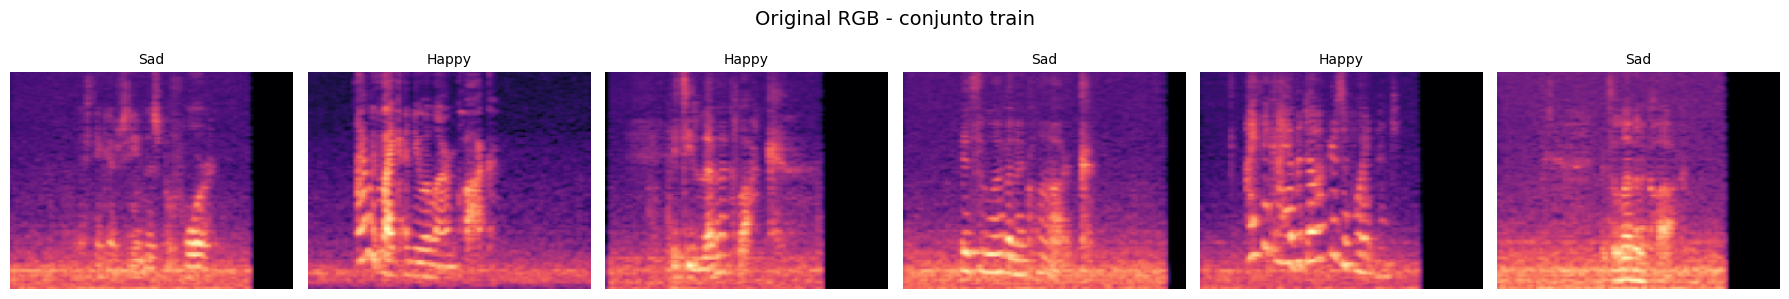

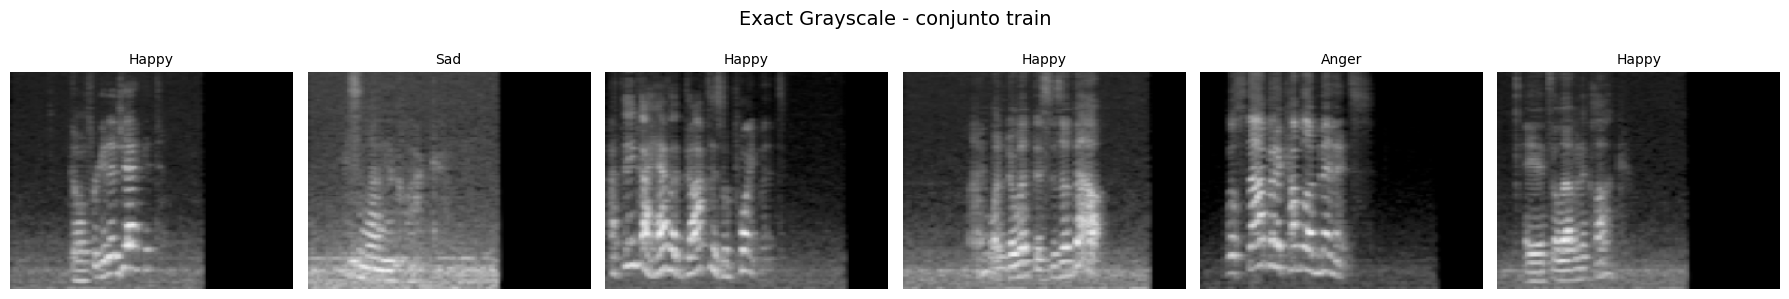

In [284]:
# RGB train
show_exact_images_from_dataloader(
    color_dataloaders['train'],
    phase='train',
    n_images=6,
    prefix='Original RGB',
    grayscale=False
)

# Grayscale val
show_exact_images_from_dataloader(
    gray_dataloaders['train'],
    phase='train',
    n_images=6,
    prefix='Exact Grayscale',
    grayscale=True
)

# De acá para abajo no se 

In [6]:
data_dir = 'CremaD/mel_spec_reduced_HAP_SAD'

dataloaders, dataset_sizes, class_names = get_dataloaders(
    data_dir=data_dir, batch_size=1, shuffle=True, spec_augment=True
)

n_classes = len(class_names)

In [7]:
# Contar imágenes por clase
import collections

def count_images_per_class(dataloaders, class_names):
    """
    Cuenta la cantidad de imágenes por clase en los conjuntos de entrenamiento y validación.
    
    Parámetros:
    - dataloaders (dict): Diccionario con los DataLoader (e.g., 'train', 'val').
    - class_names (list): Lista de nombres de clases.
    
    Retorna:
    - dict: Diccionario con conteos por clase para 'train' y 'val'.
    """
    class_counts = {'train': collections.defaultdict(int), 'val': collections.defaultdict(int)}
    for phase in ['train', 'val']:
        for inputs, labels in dataloaders[phase]:
            for label in labels:
                class_counts[phase][class_names[label]] += 1
    return {phase: dict(counts) for phase, counts in class_counts.items()}

# Ejecutar conteo
class_distribution = count_images_per_class(dataloaders, class_names)
print("Cantidad de imágenes por clase:")
for phase in ['train', 'val']:
    print(f"Conjunto {phase}:")
    for class_name, count in class_distribution[phase].items():
        print(f"{class_name}: {count} imágenes")

Cantidad de imágenes por clase:
Conjunto train:
Happy: 448 imágenes
Sad: 449 imágenes
Conjunto val:
Happy: 249 imágenes
Sad: 248 imágenes


In [8]:
inputs, labels = next(iter(dataloaders['train']))
print("Sample shape:", inputs[0].shape)
print(f"Número total de clases: {len(class_names)}")

Sample shape: torch.Size([3, 224, 224])
Número total de clases: 2


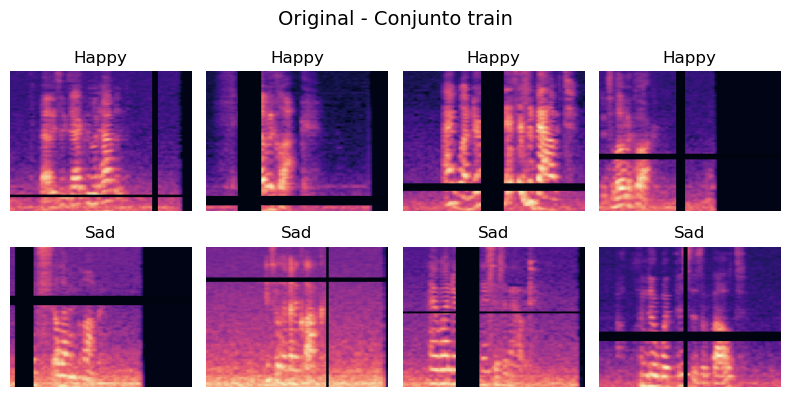

Shape de la muestra en train Original: torch.Size([3, 224, 224])


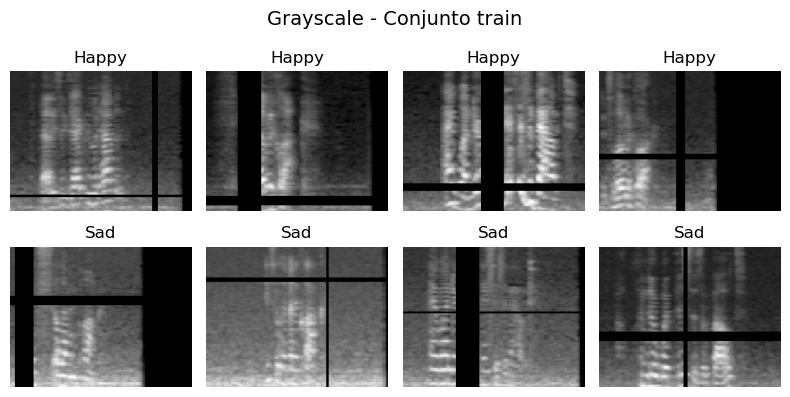

Shape de la muestra en train Grayscale: torch.Size([1, 224, 224])


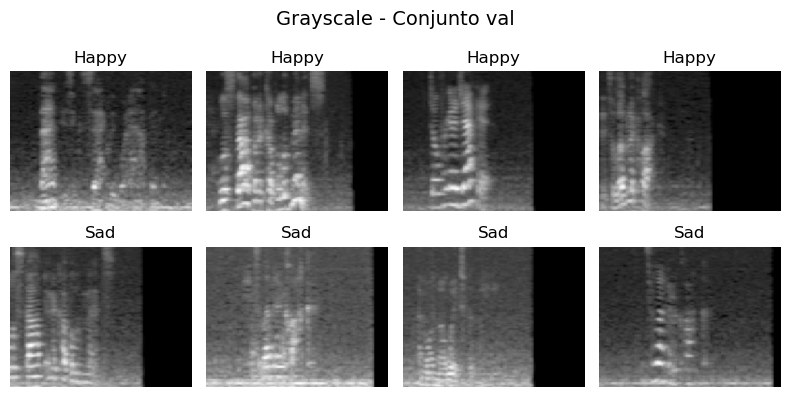

Shape de la muestra en val Grayscale: torch.Size([1, 224, 224])


In [9]:
# Visualización de mel-spectrogramas
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def visualize_mel_spectrograms(data_samples, class_names, n_samples=4, phase='', title_prefix=""):
    """
    Visualiza un grid de mel-spectrogramas para un conjunto específico.
    
    Parámetros:
    - data_samples (dict): Diccionario con listas de muestras por clase.
    - class_names (list): Lista de nombres de clases.
    - n_samples (int): Número de muestras por clase a mostrar (default: 4).
    - phase (str): Nombre de la fase ('train', 'val', etc., default: '').
    - title_prefix (str): Prefijo para el título de la figura (default: "").
    """
    # Crear grid
    n_classes_to_show = min(len(class_names), 2)  # Máximo 2 clases por figura
    fig, axes = plt.subplots(n_classes_to_show, n_samples, figsize=(n_samples * 2, n_classes_to_show * 2))
    axes = axes if n_classes_to_show > 1 else [axes]  # Ajuste si solo hay una clase

    for i, class_name in enumerate(class_names[:n_classes_to_show]):
        samples = data_samples[class_name][:n_samples]
        for j, sample in enumerate(samples):
            ax = axes[i][j]
            # Visualizar directamente los datos pasados
            img_data = sample.cpu().numpy()
            if img_data.ndim == 4 and img_data.shape[1] == 3:  # [batch, 3, 224, 224]
                img_data = img_data.transpose(0, 2, 3, 1).squeeze(0)  # [224, 224, 3]
            elif img_data.ndim == 4 and img_data.shape[1] == 1:  # [batch, 1, 224, 224]
                img_data = img_data.transpose(0, 2, 3, 1).squeeze(0).squeeze(-1)  # [224, 224]
            elif img_data.ndim == 3 and img_data.shape[0] == 3:  # [3, 224, 224]
                img_data = img_data.transpose(1, 2, 0)  # [224, 224, 3]
            elif img_data.ndim == 3 and img_data.shape[0] == 1:  # [1, 224, 224]
                img_data = img_data.transpose(1, 2, 0).squeeze(-1)  # [224, 224]
            min_val, max_val = -2.118, 2.3935575  # Basado en mensajes de clipping
            img_data = (img_data - min_val) / (max_val - min_val)  # Normalizar a [0, 1]
            img_data = np.clip(img_data, 0, 1)  # Asegurar rango válido
            ax.imshow(img_data, cmap='gray' if img_data.ndim == 2 else None, aspect='auto')
            ax.set_title(f"{class_name}")
            ax.axis('off')

    # Ajustar el espaciado para evitar superposición del título
    fig.subplots_adjust(top=0.92)
    fig.suptitle(f"{title_prefix} - Conjunto {phase}", fontsize=14)
    plt.tight_layout()
    plt.show()
    print(f"Shape de la muestra en {phase} {title_prefix}: {sample.shape}")

# Definir transformación a escala de grises
gray_transform = transforms.Grayscale(num_output_channels=1)

# Obtener datos originales de train
data_samples_train_orig = {}
for inputs, labels in dataloaders['train']:
    for img, label in zip(inputs, labels):
        class_name = class_names[label]
        if class_name not in data_samples_train_orig:
            data_samples_train_orig[class_name] = []
        if len(data_samples_train_orig[class_name]) < 4:
            data_samples_train_orig[class_name].append(img)
    if all(len(samples) >= 4 for samples in data_samples_train_orig.values()):
        break

# Visualizar datos originales de train (RGB)
visualize_mel_spectrograms(data_samples_train_orig, class_names, n_samples=4, phase='train', title_prefix="Original")

# Transformar datos de train a escala de grises y guardar
data_samples_train_gray = {}
for class_name in data_samples_train_orig:
    data_samples_train_gray[class_name] = [gray_transform(sample.unsqueeze(0)).squeeze(1) for sample in data_samples_train_orig[class_name]]

# Visualizar datos transformados de train (Grayscale)
visualize_mel_spectrograms(data_samples_train_gray, class_names, n_samples=4, phase='train', title_prefix="Grayscale")

# Obtener y transformar datos de val a escala de grises y guardar
data_samples_val_gray = {}
for inputs, labels in dataloaders['val']:
    for img, label in zip(inputs, labels):
        class_name = class_names[label]
        if class_name not in data_samples_val_gray:
            data_samples_val_gray[class_name] = []
        if len(data_samples_val_gray[class_name]) < 4:
            data_samples_val_gray[class_name].append(gray_transform(img.unsqueeze(0)).squeeze(1))
    if all(len(samples) >= 4 for samples in data_samples_val_gray.values()):
        break

# Visualizar datos transformados de val (Grayscale)
visualize_mel_spectrograms(data_samples_val_gray, class_names, n_samples=4, phase='val', title_prefix="Grayscale")


# Visualización de mel-spectrogramas en escala de grises
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_mel_spectrograms(dataloaders, class_names, n_samples=8):
#     """
#     Visualiza un grid de mel-spectrogramas de cada clase en escala de grises.
    
#     Parámetros:
#     - dataloaders (dict): Diccionario con los DataLoader (e.g., 'train').
#     - class_names (list): Lista de nombres de clases.
#     - n_samples (int): Número de muestras por clase a mostrar (default: 8).
#     """
#     # Obtener muestras de cada clase
#     samples_per_class = {name: [] for name in class_names}
#     for inputs, labels in dataloaders['train']:
#         for img, label in zip(inputs, labels):
#             class_name = class_names[label]
#             if len(samples_per_class[class_name]) < n_samples:
#                 samples_per_class[class_name].append(img)
#             if all(len(samples) >= n_samples for samples in samples_per_class.values()):
#                 break
#         if all(len(samples) >= n_samples for samples in samples_per_class.values()):
#             break

#     # Crear grid 4x4
#     n_classes_to_show = min(len(class_names), 4)  # Máximo 4 clases en el grid
#     fig, axes = plt.subplots(n_classes_to_show, n_samples, figsize=(n_samples * 2, n_classes_to_show * 2))
#     axes = axes if n_classes_to_show > 1 else [axes]  # Ajuste si solo hay una clase

#     for i, class_name in enumerate(class_names[:n_classes_to_show]):
#         samples = samples_per_class[class_name][:n_samples]
#         for j, sample in enumerate(samples):
#             ax = axes[i][j] if n_classes_to_show > 1 else axes[j]
#             # Convertir a escala de grises y remapear al rango [0, 1]
#             img_data = sample.cpu().numpy().transpose(1, 2, 0)  # [3, 224, 224] → [224, 224, 3]
#             gray_data = np.mean(img_data, axis=2)  # Promedio de los 3 canales a [224, 224]
#             # Remapear de [-2.118, 2.3935575] a [0, 1]
#             min_val, max_val = -2.118, 2.3935575  # Basado en los mensajes de clipping
#             gray_data = (gray_data - min_val) / (max_val - min_val)  # Normalizar a [0, 1]
#             gray_data = np.clip(gray_data, 0, 1)  # Asegurar rango válido
#             ax.imshow(gray_data, cmap='gray', aspect='auto')
#             ax.set_title(f"{class_name}")
#             ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Ejecutar visualización
# visualize_mel_spectrograms(dataloaders, class_names)

## 2. Perceptron

### 2.1 Perceptron con datos en grayscale

In [130]:
# Entrenamiento de un perceptrón con mel-spectrogramas en escala de grises
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms

# Definir transformación a escala de grises
gray_transform = transforms.Grayscale(num_output_channels=1)

# Extraer datos del DataLoader y transformarlos a escala de grises
def extract_data(dataloaders, phase='train', transform=None):
    images, labels = [], []
    for inputs, lbls in dataloaders[phase]:
        if transform:
            inputs = transform(inputs)  # Aplicar transformación a escala de grises
            inputs = inputs.squeeze(1)  # Eliminar dimensión del canal, de [batch, 1, 224, 224] a [batch, 224, 224]
        images.append(inputs.cpu().numpy())
        labels.append(lbls.cpu().numpy())
    return np.vstack(images), np.concatenate(labels)

# Obtener datos de train y test transformados a grises
X_train, y_train = extract_data(dataloaders, 'train', transform=gray_transform)
X_test, y_test = extract_data(dataloaders, 'val', transform=gray_transform)  # Asumiendo que tienes un conjunto de validación

# Verificar formas
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Vectorizar las imágenes (de [n_samples, 224, 224] a [n_samples, 224*224])
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"X_train_flat shape: {X_train_flat.shape}, X_test_flat shape: {X_test_flat.shape}")

# Entrenar el perceptrón
clf = Perceptron(max_iter=50, random_state=0, verbose=True)
clf.fit(X_train_flat, y_train)

# Predicción
y_pred = clf.predict(X_test_flat)

# Calcular accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {acc*100:.2f}%")

X_train shape: (897, 224, 224), y_train shape: (897,)
X_test shape: (497, 224, 224), y_test shape: (497,)
X_train_flat shape: (897, 50176), X_test_flat shape: (497, 50176)
-- Epoch 1
Norm: 2118.12, NNZs: 50176, Bias: 5.000000, T: 897, Avg. loss: 11727.091499
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 2917.65, NNZs: 50176, Bias: 9.000000, T: 1794, Avg. loss: 10245.025257
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 3520.33, NNZs: 50176, Bias: 10.000000, T: 2691, Avg. loss: 8938.371992
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 4179.74, NNZs: 50176, Bias: 10.000000, T: 3588, Avg. loss: 8530.950149
Total training time: 0.18 seconds.
-- Epoch 5
Norm: 4610.49, NNZs: 50176, Bias: 12.000000, T: 4485, Avg. loss: 7226.499682
Total training time: 0.22 seconds.
-- Epoch 6
Norm: 5111.97, NNZs: 50176, Bias: 11.000000, T: 5382, Avg. loss: 7850.568223
Total training time: 0.26 seconds.
-- Epoch 7
Norm: 5486.81, NNZs: 50176, Bias: 13.000000, T: 6279, Avg. loss: 6302.651513
Tot

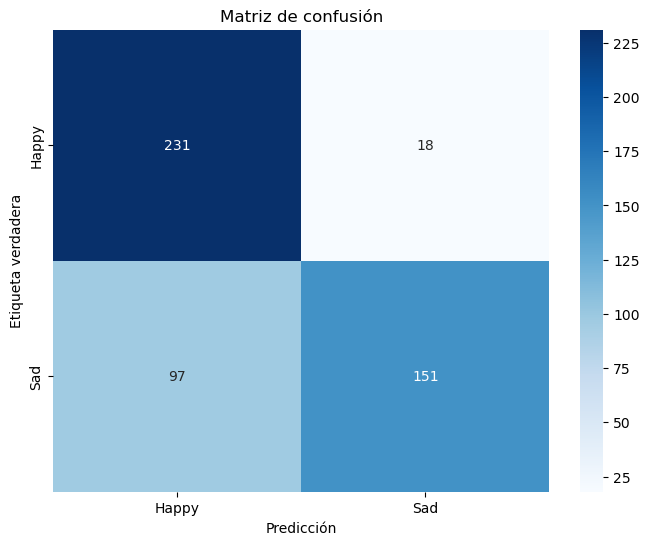

In [131]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de confusión")
plt.show()

### 2.2 Perceptron con datos en RGB

X_train shape: (897, 3, 224, 224), y_train shape: (897,)
X_test shape: (497, 3, 224, 224), y_test shape: (497,)
X_train_flat shape: (897, 150528), X_test_flat shape: (497, 150528)
-- Epoch 1
Norm: 4445.94, NNZs: 150528, Bias: -1.000000, T: 897, Avg. loss: 33868.848843
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 6197.40, NNZs: 150528, Bias: -2.000000, T: 1794, Avg. loss: 21962.837791
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 7307.54, NNZs: 150528, Bias: -4.000000, T: 2691, Avg. loss: 19085.914113
Total training time: 0.42 seconds.
-- Epoch 4
Norm: 8245.66, NNZs: 150528, Bias: -4.000000, T: 3588, Avg. loss: 15886.034303
Total training time: 0.55 seconds.
-- Epoch 5
Norm: 9056.93, NNZs: 150528, Bias: -4.000000, T: 4485, Avg. loss: 15240.919863
Total training time: 0.68 seconds.
-- Epoch 6
Norm: 9816.91, NNZs: 150528, Bias: -5.000000, T: 5382, Avg. loss: 12504.276012
Total training time: 0.81 seconds.
-- Epoch 7
Norm: 10507.77, NNZs: 150528, Bias: -6.000000, T: 6279, Avg.

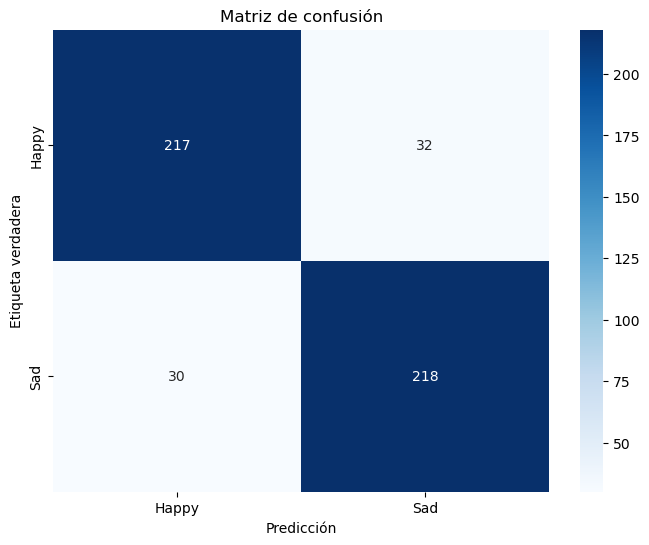

In [132]:
# Entrenamiento de un perceptrón con mel-spectrogramas
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# from tqdm import tqdm  # Para una barra de progreso (opcional, "chiche")

# Extraer datos del DataLoader
def extract_data(dataloaders, phase='train'):
    images, labels = [], []
    for inputs, lbls in dataloaders[phase]:
        images.append(inputs.cpu().numpy())
        labels.append(lbls.cpu().numpy())
    return np.vstack(images), np.concatenate(labels)

# Obtener datos de train y test
X_train, y_train = extract_data(dataloaders, 'train')
X_test, y_test = extract_data(dataloaders, 'val')  # Asumiendo que tienes un conjunto de validación

# Verificar formas
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Vectorizar las imágenes (de [n_samples, 3, 224, 224] a [n_samples, 3*224*224])
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"X_train_flat shape: {X_train_flat.shape}, X_test_flat shape: {X_test_flat.shape}")

# Entrenar el perceptrón
clf = Perceptron(max_iter=50, random_state=0, verbose=True)
clf.fit(X_train_flat, y_train)

# Predicción
y_pred = clf.predict(X_test_flat)

# Calcular accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {acc*100:.2f}%")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de confusión")
plt.show()

# Opcional: Gráfico de accuracy por iteración (si el perceptrón lo permite)
# Nota: El Perceptron de scikit-learn no devuelve métricas por iteración nativamente,
# pero puedes simularlo con un bucle manual si quieres un "chiche" adicional

# 3. Etapa cuántica

In [7]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.quantum_info import DensityMatrix, entanglement_of_formation
from qiskit.visualization import plot_state_city
from qiskit.circuit import Parameter

In [115]:
base_model = 'resnet18'
n_qubits = 2                     # Number of qubits
quantum = True                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '512_nq_2'     # Possible choices: '512_2','512_nq_2','551_512_2'. 
step = 0.0007                     # Learning rate
batch_size = 8                   # Number of samples for each training step
num_epochs = 30                  # Number of training epochs
q_depth = 3                      # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

Circuito cuántico detallado (nivel device):


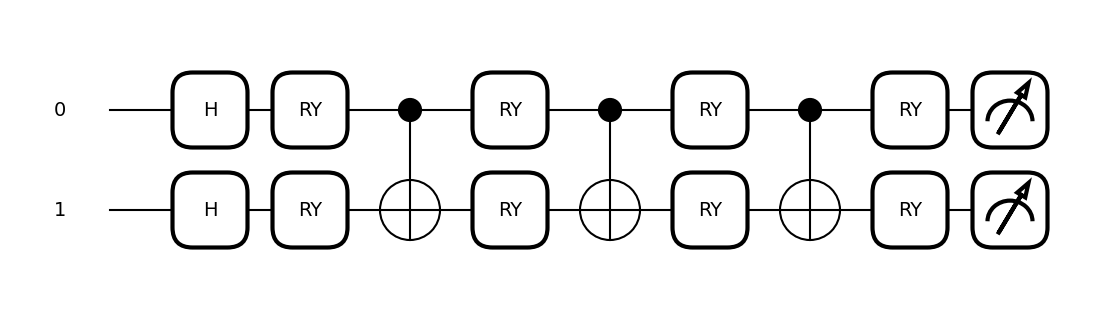

Parámetros de entrada dummy: tensor([0.4285, 0.1561], dtype=torch.float64, requires_grad=True)
Parámetros de pesos dummy: tensor([-0.0043,  0.0084, -0.0090, -0.0094, -0.0069,  0.0069, -0.0027,  0.0023,
        -0.0087, -0.0033, -0.0019, -0.0074,  0.0052,  0.0083,  0.0025, -0.0089,
        -0.0026, -0.0018, -0.0003,  0.0034, -0.0069,  0.0004,  0.0059,  0.0042,
         0.0087, -0.0016, -0.0052,  0.0099, -0.0090,  0.0012],
       dtype=torch.float64, requires_grad=True)


In [135]:
import pennylane as qml
import matplotlib.pyplot as plt
import torch

# Configurar dispositivo
dev = qml.device("default.qubit", wires=n_qubits)

# Construir el QNode
q_net = build_qnode(n_qubits, q_depth, max_layers, dev)

# Generar parámetros dummy
dummy_inputs = torch.tensor(np.random.uniform(0, np.pi/2, n_qubits), requires_grad=True)
dummy_weights = torch.tensor(np.random.uniform(-q_delta, q_delta, max_layers * n_qubits), requires_grad=True)

# Dibujar el circuito detallado (nivel device, descompuesto)
print("Circuito cuántico detallado (nivel device):")
fig, ax = qml.draw_mpl(q_net, level="device")(dummy_inputs, dummy_weights)
plt.show()

# Mostrar parámetros (acceder manualmente a los parámetros pasados)
print("Parámetros de entrada dummy:", dummy_inputs)
print("Parámetros de pesos dummy:", dummy_weights)

Circuito de Pablo

Resultado: [tensor(0.0123, dtype=torch.float64, grad_fn=<DotBackward0>), tensor(0.0081, dtype=torch.float64, grad_fn=<DotBackward0>)]
Gradientes: tensor([0.2378, 0.4550]) tensor([ 0.1215, -0.0092,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])


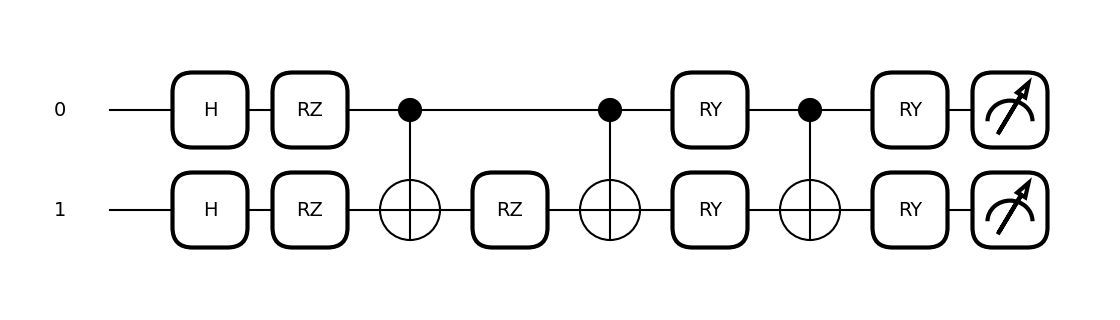

In [251]:
import pennylane as qml
import torch
import numpy as np

def zz_feature_map(x, n_qubits, reps=1):
    for _ in range(reps):
        # Hadamard en todos los qubits
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
            qml.RZ(2 * x[i], wires=i)
        # Correlaciones ZZ
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(2 * (np.pi-x[i]) * (np.pi-x[i+1]), wires=i+1)
            # print(2 * x[i] * x[i+1])
            qml.CNOT(wires=[i, i+1])

def real_amplitudes2(params, n_qubits, reps=2):
    for j in range(reps):
        for i in range(n_qubits):
            qml.RY(params[i], wires=i)
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i, i+1])
        for i in range(n_qubits):
            qml.RY(params[i], wires=i)

def real_amplitudes(params, n_qubits, reps=1):
    """
    Ansatz tipo RealAmplitudes sin el último CNOT redundante.
    - reps=1 → solo RY en cada qubit
    - reps>1 → [RY → CNOT → RY] repetido, sin último CNOT al final
    """
    if reps == 1:
        # Solo una capa de rotaciones RY
        for i in range(n_qubits):
            qml.RY(params[i], wires=i)
    else:
        for j in range(reps):
            # Rotaciones RY
            for i in range(n_qubits):
                qml.RY(params[i], wires=i)
            # Conexiones entre qubits, excepto en la última repetición
            if j < reps - 1:
                for i in range(n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])


dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def qnode(x_vec, theta_vec, n_qubits):
    zz_feature_map(x_vec, n_qubits, reps=1)
    real_amplitudes(theta_vec, n_qubits, reps=2)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

theta_example = torch.nn.Parameter(
    torch.empty(4*2).uniform_(-0.7, 0.7)
)
x_example = torch.nn.Parameter(
    torch.empty(2).uniform_(0, np.pi/2)
)

# dummy_inputs = torch.tensor(np.random.uniform(0, np.pi/2, n_qubits), requires_grad=True)
# dummy_weights = torch.tensor(np.random.uniform(-q_delta, q_delta, max_layers * n_qubits), requires_grad=True)
out = qnode(x_example, theta_example, n_qubits=2)
print("Resultado:", out)
out[0].backward()
print("Gradientes:", x_example.grad, theta_example.grad)
qml.draw_mpl(qnode)(x_example, theta_example, n_qubits=2)
plt.show()


Circuito en QASM:
 OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
h q[0];
rz(0.2763322591781616) q[0];
h q[1];
rz(2.4219231605529785) q[1];
cx q[0],q[1];
rz(11.597018241882324) q[1];
cx q[0],q[1];
ry(0.07511347532272339) q[0];
ry(-0.14655810594558716) q[1];
cx q[0],q[1];
ry(0.07511347532272339) q[0];
ry(-0.14655810594558716) q[1];


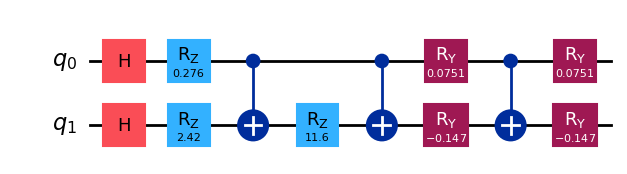

In [252]:
import numpy as np
from qiskit import QuantumCircuit

def pennylane_to_qasm(qnode, x_vec, theta_vec, n_qubits=2):
    # Construir la cinta desde el QNode
    tape = qnode.construct([x_vec, theta_vec, n_qubits], {})
    if tape is None:
        raise ValueError("No se pudo construir la cinta del QNode.")

    qasm_lines = ["OPENQASM 2.0;", 'include "qelib1.inc";', f"qreg q[{len(tape.wires)}];"]

    for op in tape.operations:
        if op.name == "Hadamard":
            qasm_lines.append(f"h q[{op.wires[0]}];")

        elif op.name == "RZ":
            angle = float(op.parameters[0])
            qasm_lines.append(f"rz({angle}) q[{op.wires[0]}];")

        elif op.name == "RY":
            angle = float(op.parameters[0])
            qasm_lines.append(f"ry({angle}) q[{op.wires[0]}];")

        elif op.name == "CNOT":
            qasm_lines.append(f"cx q[{op.wires[0]}],q[{op.wires[1]}];")

        else:
            print(f"[WARN] Puerta no soportada en QASM: {op.name}")

    return "\n".join(qasm_lines)

# Generar QASM desde el QNode
qasm_str = pennylane_to_qasm(qnode, x_example, theta_example, n_qubits=2)
print("Circuito en QASM:\n", qasm_str)

# Convertir QASM → Qiskit
qiskit_circuit = QuantumCircuit.from_qasm_str(qasm_str)
qiskit_circuit.draw(output='mpl')
plt.show()



In [44]:
qiskit_circuit.parameters

ParameterView([])

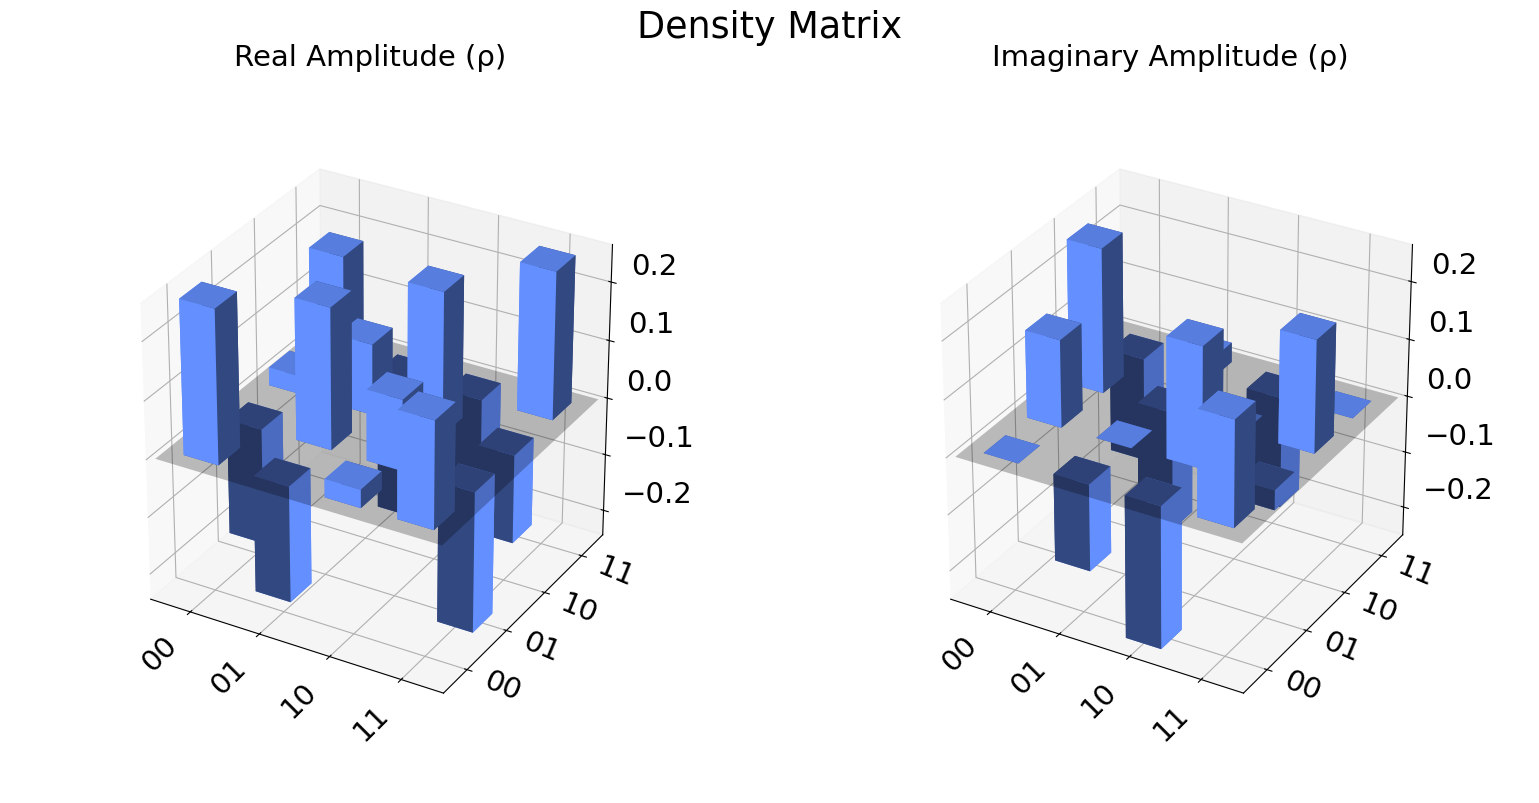

In [253]:
rho_01 = DensityMatrix.from_instruction(qiskit_circuit)

plot_state_city(rho_01.data, title='Density Matrix')

plt.show()


In [254]:
gamma_p = rho_01.purity()
display(rho_01.draw('latex', prefix='\\rho_p = '))
print("State purity: ", np.round(np.real(gamma_p)))
print(f'Entanglement: {entanglement_of_formation(rho_01):.4f}')

<IPython.core.display.Latex object>

State purity:  1.0
Entanglement: 0.5938


Circuito en QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
h q[0];
h q[1];
h q[2];
h q[3];
ry(0.5) q[0];
ry(0.30000001192092896) q[1];
ry(0.699999988079071) q[2];
ry(0.8999999761581421) q[3];
cx q[0],q[1];
cx q[2],q[3];
cx q[1],q[2];
ry(0.0) q[0];
ry(1.0) q[1];
ry(2.0) q[2];
ry(3.0) q[3];
cx q[0],q[1];
cx q[2],q[3];
cx q[1],q[2];
ry(4.0) q[0];
ry(5.0) q[1];
ry(6.0) q[2];
ry(7.0) q[3];
cx q[0],q[1];
cx q[2],q[3];
cx q[1],q[2];
ry(8.0) q[0];
ry(9.0) q[1];
ry(10.0) q[2];
ry(11.0) q[3];

Circuito en Qiskit (texto):
     ┌───┐┌─────────┐     ┌───────┐              ┌───────┐              »
q_0: ┤ H ├┤ Ry(0.5) ├──■──┤ Ry(0) ├───────────■──┤ Ry(4) ├───────────■──»
     ├───┤├─────────┤┌─┴─┐└───────┘┌───────┐┌─┴─┐└───────┘┌───────┐┌─┴─┐»
q_1: ┤ H ├┤ Ry(0.3) ├┤ X ├────■────┤ Ry(1) ├┤ X ├────■────┤ Ry(5) ├┤ X ├»
     ├───┤├─────────┤└───┘  ┌─┴─┐  ├───────┤└───┘  ┌─┴─┐  ├───────┤└───┘»
q_2: ┤ H ├┤ Ry(0.7) ├──■────┤ X ├──┤ Ry(2) ├──■────┤ X ├──┤ Ry(6) ├──■──»
     ├───┤├─────────┤┌─┴─┐┌─┴───┴

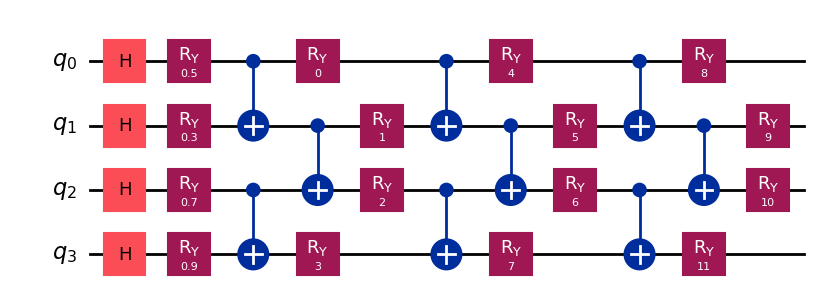

In [33]:
import pennylane as qml
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
import torch

# Definir funciones del circuito
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

# Constructor de QNode
def build_qnode(n_qubits, q_depth, max_layers, dev):
    @qml.qnode(dev, interface='torch')
    def q_net(q_in, q_weights_flat):
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        H_layer(n_qubits)
        RY_layer(q_in)
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k])
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]
    return q_net

# Parámetros y dispositivo
n_qubits = 4
q_depth = 3
max_layers = 15
dev = qml.device('default.qubit', wires=n_qubits)
params = torch.tensor([0.5, 0.3, 0.7, 0.9], requires_grad=True)  # q_in, tamaño n_qubits=4
weights = torch.tensor(list(range(60)), dtype=torch.float32, requires_grad=True)  # q_weights_flat, tamaño max_layers * n_qubits = 60

# Evaluar el QNode para generar la cinta
q_net = build_qnode(n_qubits, q_depth, max_layers, dev)
_ = q_net(params, weights)  # Esto asegura que qtape se construya

# Función para convertir Pennylane a QASM
def pennylane_to_qasm(qnode, q_in, q_weights_flat):
    tape = qnode.qtape
    if tape is None:
        raise ValueError("La cinta (qtape) no está disponible. Asegúrate de evaluar el QNode primero.")
    max_layers = q_weights_flat.shape[0] // len(qnode.qtape.wires)  # Número de qubits
    q_weights = q_weights_flat.reshape(max_layers, len(tape.wires))
    qasm_lines = ["OPENQASM 2.0;", 'include "qelib1.inc";', f"qreg q[{len(tape.wires)}];"]
    param_index = 0  # Contador para q_in
    weight_index = 0  # Contador para q_weights

    for op in tape.operations:
        if op.name == "Hadamard":
            qasm_lines.append(f"h q[{op.wires[0]}];")
        elif op.name == "RY" and param_index < len(q_in):
            qasm_lines.append(f"ry({float(q_in[param_index].detach().numpy())}) q[{op.wires[0]}];")
            param_index += 1
        elif op.name == "RY" and weight_index < q_weights.numel():
            layer_idx = weight_index // len(tape.wires)
            wire_idx = weight_index % len(tape.wires)
            qasm_lines.append(f"ry({float(q_weights[layer_idx, wire_idx].detach().numpy())}) q[{op.wires[0]}];")
            weight_index += 1
        elif op.name == "CNOT":
            qasm_lines.append(f"cx q[{op.wires[0]}],q[{op.wires[1]}];")
    return "\n".join(qasm_lines)

# Convertir a QASM
qasm_str = pennylane_to_qasm(q_net, params, weights)
print("Circuito en QASM:")
print(qasm_str)

# Convertir QASM a Qiskit y dibujar
qiskit_circuit = QuantumCircuit.from_qasm_str(qasm_str)
print("\nCircuito en Qiskit (texto):")
print(qiskit_circuit)
print("\nCircuito en Qiskit (gráfico Matplotlib):")
qiskit_circuit.draw(output='mpl')
plt.show()

tensor([0.2983, 0.0302])
Parámetros aleatorios: [-0.25069603 -0.6097536   0.66645064 -0.99075774  0.91236283  0.40367958]

Circuito en QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
h q[0];
h q[1];
ry(-0.25069602874926256) q[0];
ry(-0.6097535954262394) q[1];
cx q[0],q[1];
ry(0.6664506365419529) q[0];
ry(-0.9907577437321295) q[1];

Circuito en Qiskit (texto):
     ┌───┐┌─────────────┐      ┌─────────────┐ 
q_0: ┤ H ├┤ Ry(-0.2507) ├───■──┤ Ry(0.66645) ├─
     ├───┤├─────────────┴┐┌─┴─┐├─────────────┴┐
q_1: ┤ H ├┤ Ry(-0.60975) ├┤ X ├┤ Ry(-0.99076) ├
     └───┘└──────────────┘└───┘└──────────────┘

Matriz de densidad:
[[ 0.33677227+0.j  0.42842089+0.j -0.07166302+0.j  0.1862167 +0.j]
 [ 0.42842089+0.j  0.54501061+0.j -0.09116527+0.j  0.23689339+0.j]
 [-0.07166302+0.j -0.09116527+0.j  0.01524944+0.j -0.03962574+0.j]
 [ 0.1862167 +0.j  0.23689339+0.j -0.03962574+0.j  0.10296768+0.j]]


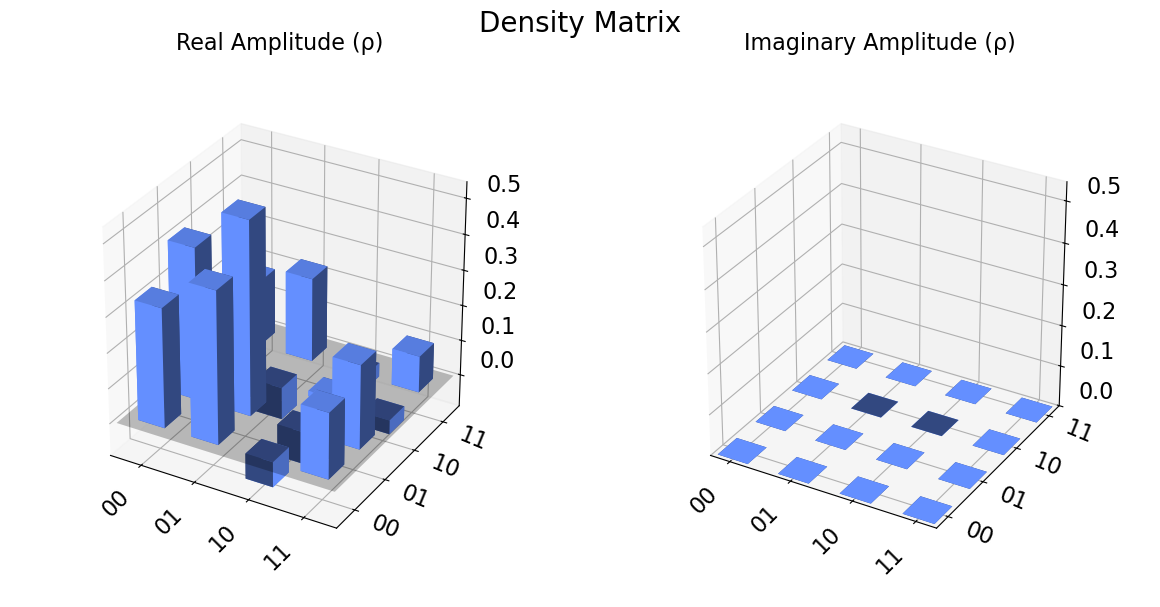

In [60]:
# Dispositivo Pennylane
n_qubits = 2
q_depth = 1
max_layers = 15
dev = qml.device('default.qubit', wires=n_qubits)

# Declarar objeto de Quantumnet
q_delta = 0.1  # Valor arbitrario para q_delta
qnn = Quantumnet(n_qubits, q_depth, max_layers, q_delta, dev)

# Evaluar el QNode con valores dummy aleatorios para generar la cinta
dummy_q_in = torch.rand(n_qubits) * np.pi / 2.0  # Valores aleatorios entre 0 y pi/2
print(dummy_q_in)
_ = qnn.q_net(dummy_q_in, qnn.q_params)  # Generar qtape

# Declarar params aleatorios
# Tamaño total: n_qubits (para q_in) + (q_depth + 1) * n_qubits (para q_weights_flat usados)
total_params_size = n_qubits + (q_depth + 1) * n_qubits  # Ajuste para q_depth capas + inicial
params = np.random.uniform(-1, 1, total_params_size)
print("Parámetros aleatorios:", params)

# Separar params en q_in y q_weights_flat para la conversión
q_in_params = params[:n_qubits]
q_weights_params = params[n_qubits:]

# Convertir a QASM
qasm_str = pennylane_to_qasm(qnn.q_net, q_in_params, q_weights_params)
print("\nCircuito en QASM:")
print(qasm_str)

# Convertir QASM a Qiskit
qiskit_circuit = QuantumCircuit.from_qasm_str(qasm_str)
print("\nCircuito en Qiskit (texto):")
print(qiskit_circuit)

# Calcular matriz de densidad
rho_01 = DensityMatrix.from_instruction(qiskit_circuit)
print("\nMatriz de densidad:")
print(rho_01.data)

# Visualización con plot_state_city
plot_state_city(rho_01.data, title='Density Matrix', figsize=(12, 6))

In [61]:
gamma_p = rho_01.purity()
display(rho_01.draw('latex', prefix='\\rho_p = '))
print("State purity: ", np.round(np.real(gamma_p), 3))

<IPython.core.display.Latex object>

State purity:  1.0


In [48]:
print(f'{entanglement_of_formation(rho_01):.4f}')

0.5431


Entrenamiento

In [349]:
# Quantum device - PennyLane
dev = qml.device('default.qubit', wires=n_qubits)
# Classical device - GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

✅ Usando dispositivo: cuda:0
NVIDIA GeForce RTX 4070 Laptop GPU


In [350]:
def build_qnode_new(n_qubits, dev, reps_feature=2, reps_ansatz=1):
    @qml.qnode(dev, interface="torch")
    def q_net(x_vec, theta_vec):
        zz_feature_map(x_vec, n_qubits, reps=reps_feature)
        real_amplitudes(theta_vec, n_qubits, reps=reps_ansatz)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    return q_net

class QuantumnetZZ(nn.Module):
    def __init__(self, n_qubits, q_depth, q_delta, max_layers, dev, n_classes=2, base_model='resnet18',
                 reps_feature=1):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.max_layers = max_layers
        self.reps_feature = reps_feature


        # QNode cuántico
        self.q_net = build_qnode_new(n_qubits, dev, reps_feature, q_depth)

        # Pre-red clásica (igual a tu original)
        if base_model == 'resnet18':
            self.pre_net = nn.Linear(512, n_qubits)
        elif base_model == 'vgg16':
            self.pre_net = nn.Sequential(
                nn.Linear(4096, 512),
                nn.ReLU(),
                nn.Linear(512, n_qubits)
            )

        # Parámetros cuánticos entrenables (ansatz)
        # self.q_params = nn.Parameter(q_delta * torch.randn(max_layers*n_qubits))
        self.q_params = nn.Parameter(q_delta * torch.randn(n_qubits))
        self.post_net = nn.Linear(n_qubits, n_classes)

    def forward(self, input_features):
        # Extraer características clásicas
        pre_out = self.pre_net(input_features)
        x_vec = torch.tanh(pre_out) * np.pi / 2.0

        # Ejecutar el circuito cuántico
        q_out = torch.zeros((0, self.n_qubits), device=input_features.device)
        for elem in x_vec:
            out_elem = torch.stack(self.q_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, out_elem))

        # Clasificación final
        return self.post_net(q_out)



In [348]:
base_model = 'resnet18'
n_qubits = 2                     # Number of qubits
quantum = True                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '512_2'     # Possible choices: '512_2','512_nq_2','551_512_2'. 
step = 0.0004                     # Learning rate
batch_size = 4                   # Number of samples for each training step
num_epochs = 30                  # Number of training epochs
q_depth = 2                      # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

In [351]:
from torchvision.models import resnet18, ResNet18_Weights

if base_model == 'resnet18':
    model_hybrid = resnet18(weights=ResNet18_Weights.DEFAULT)

    for param in model_hybrid.parameters():
        param.requires_grad = False

    if quantum:
        model_hybrid.fc = QuantumnetZZ(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=n_classes
        )

    elif classical_model == '512_2':
        model_hybrid.fc = nn.Linear(512, n_classes)
        
    elif classical_model == '512_nq_2':
        # model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, n_classes)) 
        model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, n_qubits), torch.nn.ReLU(),  nn.Linear(n_qubits, n_classes)) 

    elif classical_model == '551_512_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, n_classes))

elif base_model == 'vgg16':
    model_hybrid = torchvision.models.vgg16(pretrained=True)

    for param in model_hybrid.parameters():
        param.requires_grad = False

    if quantum:
        model_hybrid.classifier[6] = Quantumnet(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=n_classes,
            base_model=base_model
        )

    elif classical_model == '512_2':
        model_hybrid.classifier[6] = nn.Linear(4096, n_classes)
        
    elif classical_model == '512_nq_2':
        model_hybrid.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512), 
            torch.nn.ReLU(), 
            nn.Linear(512, n_qubits),
            torch.nn.ReLU(),
            nn.Linear(n_qubits, n_classes)
            ) 

    elif classical_model == '551_512_2':
        model_hybrid.classifier[6] = nn.Sequential(nn.Linear(4096, 512), torch.nn.ReLU(), nn.Linear(512, n_classes))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)
torch.manual_seed(rng_seed)

In [352]:
# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
params_to_optimize = (
    model_hybrid.fc.parameters() if base_model == 'resnet18'
    else model_hybrid.classifier[6].parameters()
)
optimizer_hybrid = optim.AdamW(params_to_optimize, lr=step)

# Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=12, gamma=gamma_lr_scheduler)


In [353]:
import os
from torchvision import datasets, transforms
from collections import Counter
from torch.utils.data import DataLoader

def create_dataloaders(data_dir,
                       batch_size=8,
                       shuffle=True,
                       num_workers=4,
                       grayscale=False):
    # Normalization stats
    mean, std = ([0.5], [0.5]) if grayscale else ([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])

    transform_list = [transforms.Resize((224, 224))]
    if grayscale:
        transform_list.append(transforms.Grayscale(num_output_channels=1))
    transform_list += [transforms.ToTensor(), transforms.Normalize(mean, std)]
    data_transform = transforms.Compose(transform_list)

    # Datasets
    image_datasets = {
        phase: datasets.ImageFolder(os.path.join(data_dir, phase),
                                    transform=data_transform)
        for phase in ['train', 'val']
    }

    dataloaders = {
        phase: DataLoader(image_datasets[phase],
                          batch_size=batch_size,
                          shuffle=(shuffle if phase == 'train' else False),
                          num_workers=num_workers)
        for phase in ['train', 'val']
    }

    dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val']}
    class_names   = image_datasets['train'].classes

    # Conteo por clase como en la función vieja
    counts_per_class = {
        phase: count_images_per_class_from_dataset(image_datasets[phase], class_names)
        for phase in ['train', 'val']
    }

    return dataloaders, dataset_sizes, class_names, counts_per_class

gray_dataloaders, dataset_sizes, class_names, counts_per_class = create_dataloaders(
    data_dir='CremaD/mel_spec_reduced',
    batch_size=batch_size,
    shuffle=True,
    grayscale=True
)


In [354]:
import time
import copy
import torch
import torch.nn as nn

def train_model(model,
                dataloaders,
                dataset_sizes,
                device,
                criterion,
                optimizer,
                scheduler,
                num_epochs):
    """
    Entrena un modelo PyTorch adaptándose a loaders RGB o grayscale,
    elimina TensorBoard y devuelve listas con la evolución de loss y acc.

    Args:
        model (nn.Module)
        dataloaders (dict): {'train': DataLoader, 'val': DataLoader}
        dataset_sizes (dict): {'train': int, 'val': int}
        device (torch.device)
        criterion: función de pérdida
        optimizer: optimizador
        scheduler: scheduler de LR
        num_epochs (int)

    Returns:
        best_model (nn.Module)
        train_losses (list[float])
        train_accs   (list[float])
        val_losses   (list[float])
        val_accs     (list[float])
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []

    # Detectar cuántos canales de entrada espera la primera Conv2d
    expected_in_ch = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            expected_in_ch = m.in_channels
            break

    print("🚀 Training started")

    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                # mover a device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # --- Adaptar canales si es grayscale → RGB ---
                # si loader da 1 canal y el modelo espera 3, duplicamos
                if inputs.dim() == 4 and inputs.size(1) == 1 and expected_in_ch == 3:
                    inputs = inputs.repeat(1, 3, 1, 1)

                optimizer.zero_grad()

                # forward + backward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # acumular métricas
                bs = inputs.size(0)
                running_loss += loss.item() * bs
                running_corrects += torch.sum(preds == labels.data).item()

            # calcular métricas por epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects / dataset_sizes[phase]

            print(f"{phase:5s} | Epoch {epoch+1}/{num_epochs} "
                  f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # guardar en listas
            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
                # checkpoint del mejor modelo
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        # step del scheduler al final de cada epoch
        scheduler.step()

    time_elapsed = time.time() - since
    print(f"✅ Training completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"🎯 Best val Acc: {best_acc:.4f}")

    # cargar pesos del mejor modelo
    model.load_state_dict(best_model_wts)

    return model, train_losses, train_accs, val_losses, val_accs


model_hybrid, train_losses, train_accs, val_losses, val_accs = train_model(
    model=model_hybrid,
    dataloaders=gray_dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    criterion=criterion,
    optimizer=optimizer_hybrid,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs
)

🚀 Training started
train | Epoch 1/30 Loss: 1.1504 Acc: 0.3226
val   | Epoch 1/30 Loss: 1.1403 Acc: 0.3205
train | Epoch 2/30 Loss: 1.1372 Acc: 0.3338
val   | Epoch 2/30 Loss: 1.1270 Acc: 0.3298
train | Epoch 3/30 Loss: 1.1204 Acc: 0.3353
val   | Epoch 3/30 Loss: 1.1128 Acc: 0.3298
train | Epoch 4/30 Loss: 1.1096 Acc: 0.3353
val   | Epoch 4/30 Loss: 1.1055 Acc: 0.3298
train | Epoch 5/30 Loss: 1.1044 Acc: 0.3353
val   | Epoch 5/30 Loss: 1.1023 Acc: 0.3298
train | Epoch 6/30 Loss: 1.1013 Acc: 0.3353
val   | Epoch 6/30 Loss: 1.1001 Acc: 0.3298
train | Epoch 7/30 Loss: 1.1000 Acc: 0.3353
val   | Epoch 7/30 Loss: 1.0993 Acc: 0.3298
train | Epoch 8/30 Loss: 1.0995 Acc: 0.3353
val   | Epoch 8/30 Loss: 1.0991 Acc: 0.3298
train | Epoch 9/30 Loss: 1.0996 Acc: 0.3361
val   | Epoch 9/30 Loss: 1.0990 Acc: 0.3298
train | Epoch 10/30 Loss: 1.0990 Acc: 0.3353
val   | Epoch 10/30 Loss: 1.0989 Acc: 0.3298
train | Epoch 11/30 Loss: 1.0989 Acc: 0.3353
val   | Epoch 11/30 Loss: 1.0988 Acc: 0.3298
train | E

KeyboardInterrupt: 

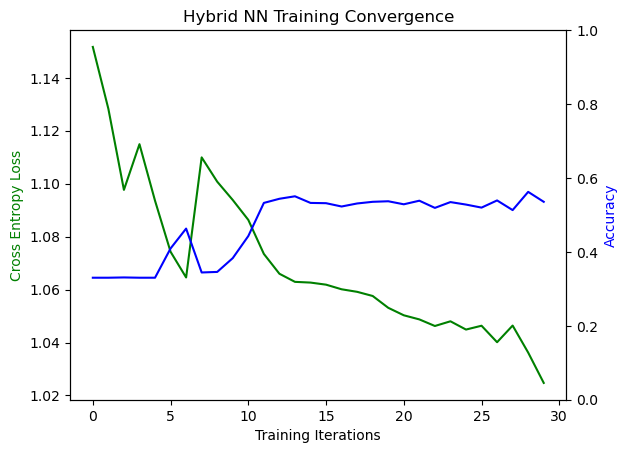

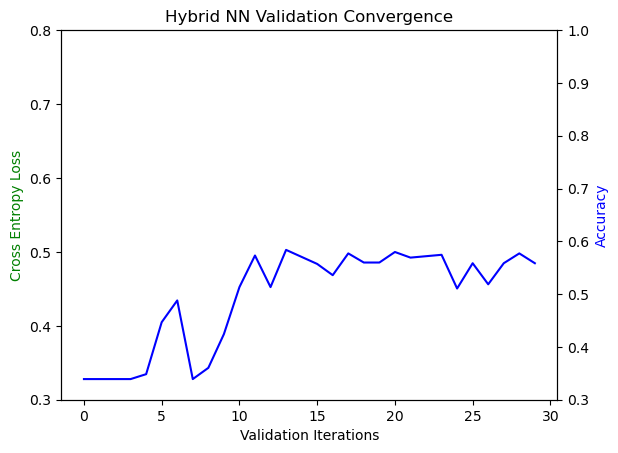

In [347]:
# Grafico de Convergencia de la función de pérdida y precisión (Train)
fig, ax1 = plt.subplots()
ax1.plot(train_losses, 'g-')
ax2 = ax1.twinx()
ax2.plot(train_accs, 'b')
ax2.set_ylim(0, 1)  # <-- Limita el eje de accuracy
plt.title("Hybrid NN Training Convergence")
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy", color='b')
plt.show()

# Grafico de Convergencia de la función de pérdida y precisión (Val)
fig, ax1 = plt.subplots()
ax1.plot(val_losses, 'g-')
ax1.set_ylim(0.3, 0.8)  # <-- Limita el eje de accuracy
ax2 = ax1.twinx()
ax2.plot(val_accs, 'b')
ax2.set_ylim(0.3, 1)  # <-- Limita el eje de accuracy
plt.title("Hybrid NN Validation Convergence")
ax1.set_xlabel("Validation Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy", color='b')
plt.show()


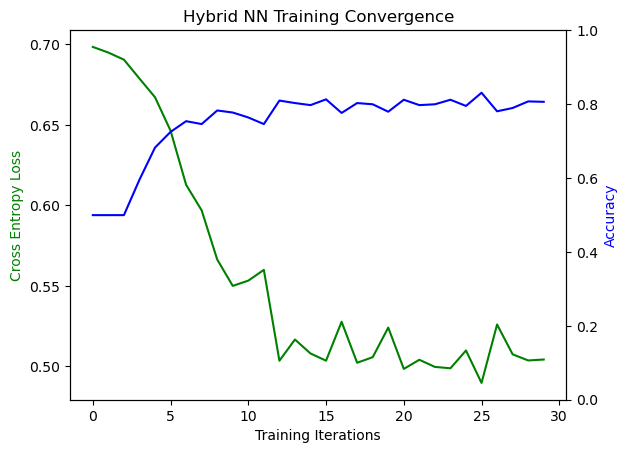

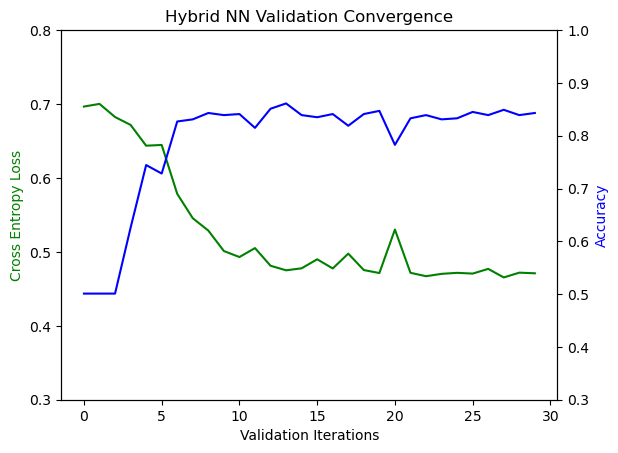

In [249]:
# Grafico de Convergencia de la función de pérdida y precisión (Train)
fig, ax1 = plt.subplots()
ax1.plot(train_losses, 'g-')
ax2 = ax1.twinx()
ax2.plot(train_accs, 'b')
ax2.set_ylim(0, 1)  # <-- Limita el eje de accuracy
plt.title("Hybrid NN Training Convergence")
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy", color='b')
plt.show()

# Grafico de Convergencia de la función de pérdida y precisión (Val)
fig, ax1 = plt.subplots()
ax1.plot(val_losses, 'g-')
ax1.set_ylim(0.3, 0.8)  # <-- Limita el eje de accuracy
ax2 = ax1.twinx()
ax2.plot(val_accs, 'b')
ax2.set_ylim(0.3, 1)  # <-- Limita el eje de accuracy
plt.title("Hybrid NN Validation Convergence")
ax1.set_xlabel("Validation Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy", color='b')
plt.show()


In [273]:
import json
import os
from datetime import datetime

def save_run(model, train_losses, train_accs, val_losses, val_accs,
             output_dir="runs", model_name="hybrid_model"):
    """
    Guarda el modelo y las métricas de entrenamiento/validación en archivos.
    - modelo: .pt
    - métricas: .json
    """
    os.makedirs(output_dir, exist_ok=True)

    # Timestamp para identificar cada corrida
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Guardar modelo
    model_path = os.path.join(output_dir, f"{model_name}_{timestamp}.pt")
    torch.save(model.state_dict(), model_path)

    # Guardar métricas
    metrics = {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "timestamp": timestamp
    }
    metrics_path = os.path.join(output_dir, f"{model_name}_{timestamp}.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"Modelo guardado en {model_path}")
    print(f"Métricas guardadas en {metrics_path}")

save_run(model_hybrid,
         train_losses, train_accs,
         val_losses, val_accs,
         output_dir="runs_updated",
         model_name="classic_model")


Modelo guardado en runs_updated\classic_model_20250724_162000.pt
Métricas guardadas en runs_updated\classic_model_20250724_162000.json


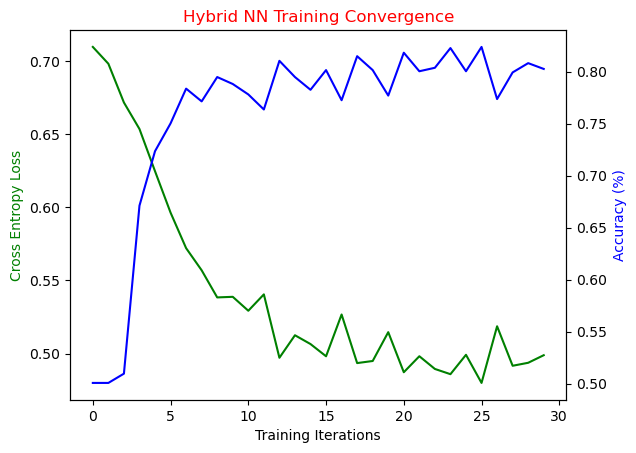

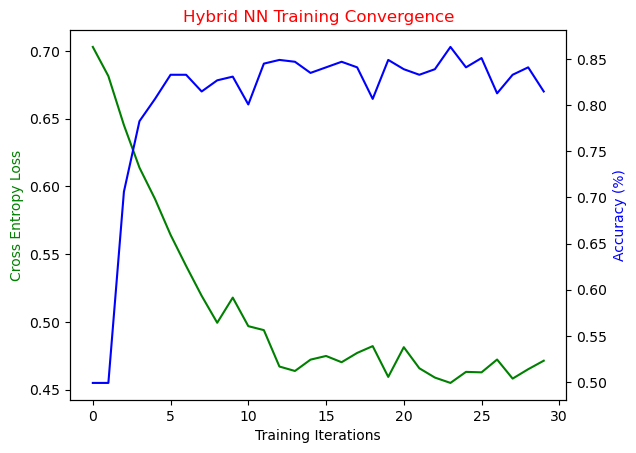

In [136]:
# Grafico de Convergencia de la función de pérdida y precisión
fig, ax1 = plt.subplots()
ax1.plot(train_losses, 'g-')
ax2 = ax1.twinx()
ax2.plot(train_accs, 'b')
plt.title("Hybrid NN Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

# Grafico de Convergencia de la función de pérdida y precisión
fig, ax1 = plt.subplots()
ax1.plot(val_losses, 'g-')
ax2 = ax1.twinx()
ax2.plot(val_accs, 'b')
plt.title("Hybrid NN Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [119]:
import os
import torch

def save_model(model, save_dir='models/gray', filename='model_gray.pth', 
               save_full_model=False):
    """
    Save a PyTorch model (state_dict or full model) to disk.

    Args:
        model (torch.nn.Module): the model to save
        save_dir (str): directory where to save
        filename (str): name of the output file
        save_full_model (bool): if True, saves the entire model object;
                                if False, saves only state_dict
    """
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)
    filepath = os.path.join(save_dir, filename)

    if save_full_model:
        # Saves the complete model (architecture + weights)
        torch.save(model, filepath)
    else:
        # Saves only the model parameters
        torch.save(model.state_dict(), filepath)

    print(f'Model saved to {filepath}')

def load_model(model_class=None, filepath='models/gray/model_gray.pth', 
               map_location=None, load_full_model=False, **model_kwargs):
    """
    Load a PyTorch model from disk.

    Args:
        model_class (callable): constructor for the model class (required if loading state_dict)
        filepath (str): path to the saved file
        map_location: device mapping (e.g., 'cpu' or torch.device)
        load_full_model (bool): if True, loads the full model object;
                                if False, loads state_dict into model_class
        model_kwargs: keyword args to pass to model_class when instantiating

    Returns:
        model (torch.nn.Module)
    """
    if load_full_model:
        # Load entire model object
        model = torch.load(filepath, map_location=map_location)
    else:
        if model_class is None:
            raise ValueError("model_class must be provided when loading state_dict.")
        # Instantiate model and load parameters
        model = model_class(**model_kwargs)
        state_dict = torch.load(filepath, map_location=map_location)
        model.load_state_dict(state_dict)

    return model

# -----------------------------
# Example usage after training:
# -----------------------------

# 1. Save only weights
save_model(model_hybrid,
           save_dir='models/gray',
           filename='model_gray_weights.pth',
           save_full_model=False)

# 2. (Optionally) Save full model
save_model(model_hybrid,
           save_dir='models/gray',
           filename='model_gray_full.pth',
           save_full_model=True)

# -----------------------------
# Example loading:
# -----------------------------

# A) Load weights into a fresh instance of your model class:
# loaded_model = load_model(
#     model_class=MyHybridModel,
#     filepath='models/gray/model_gray_weights.pth',
#     map_location=device,
#     load_full_model=False,
#     # pass any args your model constructor needs:
#     input_size=..., num_classes=..., n_qubits=...
# )

# B) Load the complete model object:
# loaded_model = load_model(
#     filepath='models/gray/model_gray_full.pth',
#     map_location=device,
#     load_full_model=True
# )


Model saved to models/gray\model_gray_weights.pth


AttributeError: Can't pickle local object 'build_qnode.<locals>.q_net'

In [ ]:
data_dir = 'CremaD/mel_spec_reduced'

dataloaders, dataset_sizes, class_names = get_dataloaders(
    data_dir=data_dir, batch_size=batch_size, shuffle=True, spec_augment=True
)

n_classes = len(class_names)

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
if base_model == 'resnet18':
    model_hybrid = torchvision.models.resnet18(pretrained=True)

    for param in model_hybrid.parameters():
        param.requires_grad = False

    if quantum:
        model_hybrid.fc = Quantumnet(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=n_classes
        )

    elif classical_model == '512_2':
        model_hybrid.fc = nn.Linear(512, n_classes)
        
    elif classical_model == '512_nq_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, n_classes)) 

    elif classical_model == '551_512_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, n_classes))

elif base_model == 'vgg16':
    model_hybrid = torchvision.models.vgg16(pretrained=True)

    for param in model_hybrid.parameters():
        param.requires_grad = False

    if quantum:
        model_hybrid.classifier[6] = Quantumnet(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=n_classes,
            base_model=base_model
        )

    elif classical_model == '512_2':
        model_hybrid.classifier[6] = nn.Linear(4096, n_classes)
        
    elif classical_model == '512_nq_2':
        model_hybrid.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512), 
            torch.nn.ReLU(), 
            nn.Linear(512, n_qubits),
            torch.nn.ReLU(),
            nn.Linear(n_qubits, n_classes)
            ) 

    elif classical_model == '551_512_2':
        model_hybrid.classifier[6] = nn.Sequential(nn.Linear(4096, 512), torch.nn.ReLU(), nn.Linear(512, n_classes))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)
torch.manual_seed(rng_seed)

c:\Users\Lucas\anaconda3\envs\qml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\qml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
params_to_optimize = (
    model_hybrid.fc.parameters() if base_model == 'resnet18'
    else model_hybrid.classifier[6].parameters()
)
optimizer_hybrid = optim.Adam(params_to_optimize, lr=step)

# Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)


In [ ]:
prefix = "q" if quantum else "cl"
timestamp = time.strftime('%Y%m%d_%H%M%S')
log_name = f"{prefix}_emotions_{base_model}_{timestamp}_final"
print(log_name)

# writer = SummaryWriter(log_dir=f"runs/{log_name}")

model_hybrid = train_model(
    model=model_hybrid,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    criterion=criterion,
    optimizer=optimizer_hybrid,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs
)
# writer.close()

cl_emotions_resnet18_20250706_161523_final
🚀 Training started:


KeyboardInterrupt: 

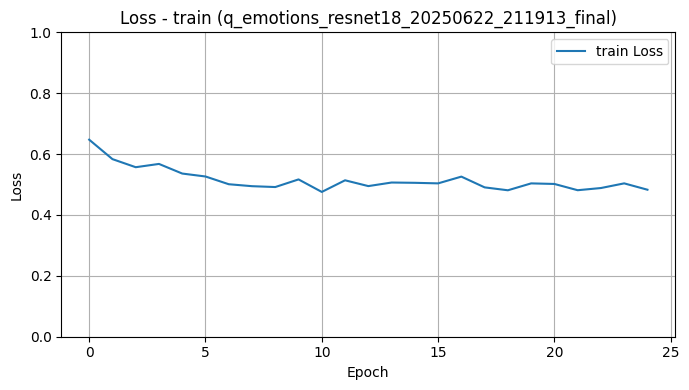

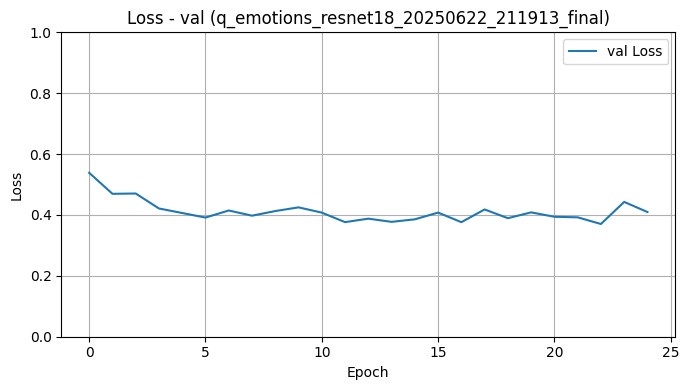

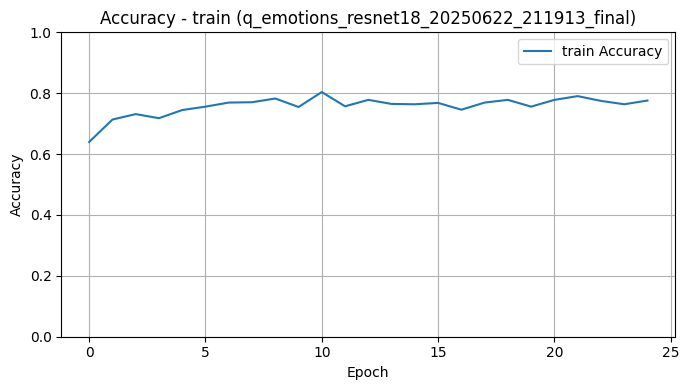

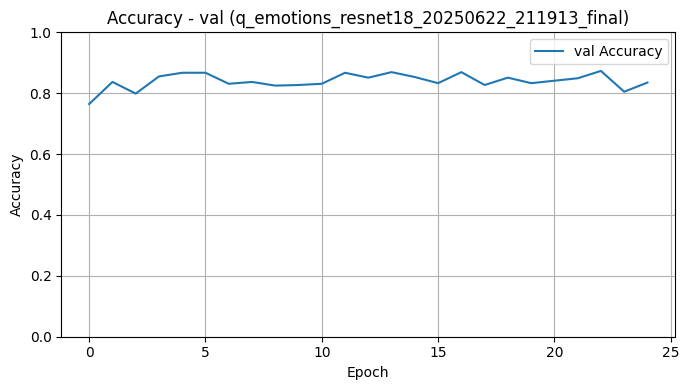

In [ ]:
plot_tensorboard_metric(f"{log_name}", metric="Loss", phase="train")
plot_tensorboard_metric(f"{log_name}", metric="Loss", phase="val")
plot_tensorboard_metric(f"{log_name}", metric="Accuracy", phase="train")
plot_tensorboard_metric(f"{log_name}", metric="Accuracy", phase="val")

# plot_tensorboard_metric("q_emotions_resnet18_20250516_173726", metric="Loss", phase="val")
# plot_tensorboard_metric("q_emotions_vgg16_20250522_172130", metric="Accuracy", phase="train")
# plot_tensorboard_metric("q_emotions_vgg16_20250522_172130", metric="Accuracy", phase="val")

In [ ]:
model_name = f"emotions_{base_model}_2306"
save_model(model_hybrid, quantum=quantum, name=model_name)

💾 Modelo guardado en: models\c_emotions_vgg16_2306.pt


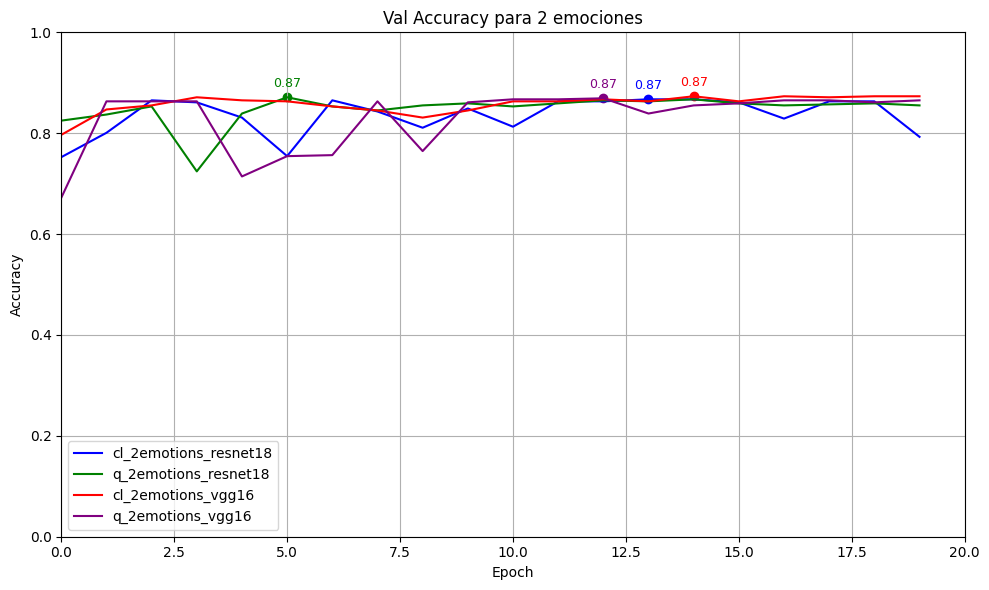

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# -----------------------------------------------------
# 🗂️ Lista con las subcarpetas de tus 4 ejecuciones
# (relativas a la carpeta 'runs')
# -----------------------------------------------------
classes_to_plot = 2
run_names = [
    f"cl_{classes_to_plot}emotions_resnet18",
    f"q_{classes_to_plot}emotions_resnet18",
    f"cl_{classes_to_plot}emotions_vgg16",
    f"q_{classes_to_plot}emotions_vgg16"
]

# Ruta base donde están guardadas las ejecuciones
runs_base_path = "runs/best_runs"

# -------------------------------
# 🎯 Extraer y graficar accuracies
# -------------------------------
plt.figure(figsize=(10, 6))
plt.title(f"Val Accuracy para {classes_to_plot} emociones")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.grid(True)

# Colores para cada curva
colors = ['blue', 'green', 'red', 'purple']

for i, run_name in enumerate(run_names):
    run_path = os.path.join(runs_base_path, run_name)

    # Buscar archivo de eventos
    event_file = next(
        (os.path.join(run_path, f) for f in os.listdir(run_path) if f.startswith("events.out.tfevents")),
        None
    )
    if event_file is None:
        print(f"⚠️ No se encontró archivo de eventos en {run_path}")
        continue

    # Cargar datos con EventAccumulator
    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()

    tag = "val/Accuracy"
    if tag not in ea.Tags().get("scalars", []):
        print(f"⚠️ La métrica {tag} no existe en {run_name}")
        continue

    # Obtener valores y epochs
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]

    # Marcar máximo
    max_acc = max(values)
    max_epoch = steps[values.index(max_acc)]

    plt.plot(steps, values, label=run_name, color=colors[i])
    plt.scatter(max_epoch, max_acc, color=colors[i], marker='o')
    plt.text(max_epoch, max_acc + 0.02, f"{max_acc:.2f}", fontsize=9, ha='center', color=colors[i])

# -------------------------------
# 🧾 Finalizar gráfico
# -------------------------------
plt.legend()
plt.tight_layout()
plt.show()


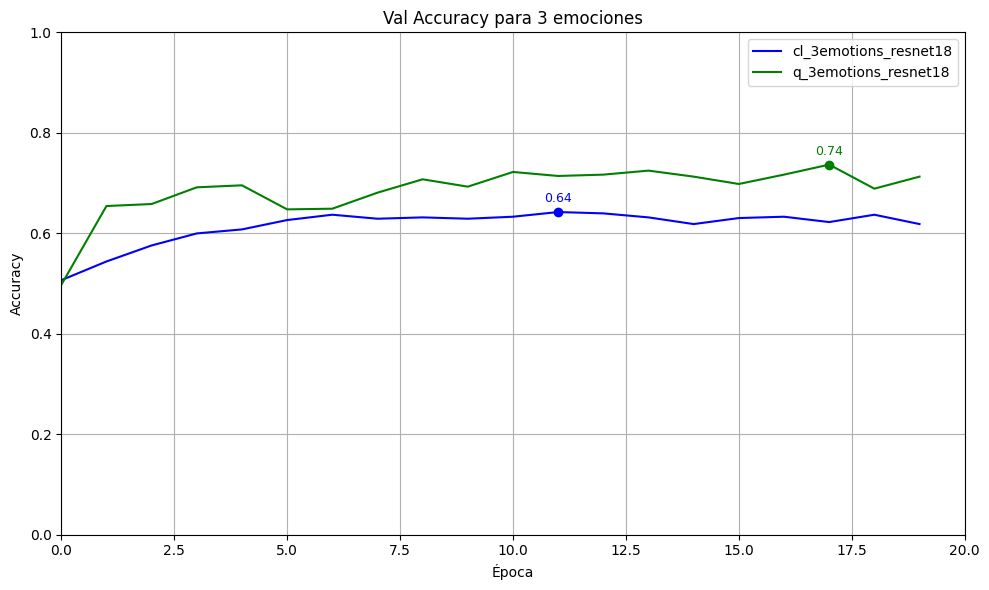

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# -----------------------------------------------------
# 🗂️ Lista con las 2 ejecuciones a comparar
# -----------------------------------------------------
classes_to_plot = 3
run_names = [
    f"cl_{classes_to_plot}emotions_resnet18",
    f"q_{classes_to_plot}emotions_resnet18"
]

# Ruta base donde están guardadas las ejecuciones
runs_base_path = "runs/best_runs"

# -------------------------------
# 🎯 Extraer y graficar accuracies
# -------------------------------
plt.figure(figsize=(10, 6))
plt.title("Val Accuracy para 3 emociones")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.grid(True)

# Colores para cada curva
colors = ['blue', 'green']

for i, run_name in enumerate(run_names):
    run_path = os.path.join(runs_base_path, run_name)

    # Buscar archivo de eventos
    event_file = next(
        (os.path.join(run_path, f) for f in os.listdir(run_path) if f.startswith("events.out.tfevents")),
        None
    )
    if event_file is None:
        print(f"⚠️ No se encontró archivo de eventos en {run_path}")
        continue

    # Cargar datos
    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()

    tag = "val/Accuracy"
    if tag not in ea.Tags().get("scalars", []):
        print(f"⚠️ La métrica {tag} no existe en {run_name}")
        continue

    # Obtener valores y epochs
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]

    # Marcar máximo
    max_acc = max(values)
    max_epoch = steps[values.index(max_acc)]

    plt.plot(steps, values, label=run_name, color=colors[i])
    plt.scatter(max_epoch, max_acc, color=colors[i], marker='o')
    plt.text(max_epoch, max_acc + 0.02, f"{max_acc:.2f}", fontsize=9, ha='center', color=colors[i])

# -------------------------------
# 🧾 Finalizar gráfico
# -------------------------------
plt.legend()
plt.tight_layout()
plt.show()
